# Eval Output Data

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.font_manager
import seaborn as sns

# Ignore all warnings including PyPSA logged ones: most of these are known trivial
# ones about old versions, Notebook settings, etc. but note you should probably
# comment this out at points to check for useful warnings!
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("pypsa").setLevel(level=logging.CRITICAL)  # ignore WARNING and below

# Style plots for better readability and accessibility
plt.style.use(['seaborn'])

# Bruno's starting ideas

In [2]:
# datadir = '/home/users/train061/group_folder/data/'
datadir = '/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_5/data/'
model = 'ICHEC'
period = '1970-1976'

In [3]:
network_d = datadir+'schlott_material/{}/{}'.format(model, period)

network = pypsa.Network(network_d)

## Features
Recommendation: Try to investigate measures which can be expressed as a function of the climate period (and potentially the node/carriers). Then, time series can be plotted and compared, similar periods can be identified, measures can be plotted against each other (scatter plots) to identify dependencies.

### Met Input Data

In [4]:
### average capacity factors for resources wind (onwind + offwind), solar PV (solar) and runoff river (ror)

n_timesteps = len(network.snapshots)  # one value, don't plot

n_generators_per_carrier = pd.Series({carrier: len(network.generators.index[network.generators.carrier==carrier])
                                     for carrier in ['onwind', 'offwind', 'solar', 'ror']})

avg_capacity_factor = network.generators_t.p_max_pu.mean() # per generator

avg_capacity_factor_per_carrier = (network.generators_t.p_max_pu.groupby(network.generators.carrier, axis=1).sum().sum()/
                                   (n_timesteps*n_generators_per_carrier)) # per carrier

avg_capacity_factor_per_carrier_and_node = network.generators_t.p_max_pu.groupby([network.generators.bus, network.generators.carrier], 
                                                                                 axis=1).sum().sum()/n_timesteps # per carrier and bus

# Collect all values with their variable name as a key in a dict
###import sys
###sys.version_info  # should be in Python 3.8 so can use the below var name getting trick
av_cap_factors = {
    f'{n_generators_per_carrier=}'.split('=')[0]: n_generators_per_carrier,
    f'{avg_capacity_factor=}'.split('=')[0]: avg_capacity_factor,
    f'{avg_capacity_factor_per_carrier=}'.split('=')[0]: avg_capacity_factor_per_carrier,
    f'{avg_capacity_factor_per_carrier_and_node=}'.split('=')[0]: avg_capacity_factor_per_carrier_and_node,
}
print(av_cap_factors)

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


{'n_generators_per_carrier': onwind     30
offwind    23
solar      30
ror        30
dtype: int64, 'avg_capacity_factor': AT onwind     0.334527
AT solar      0.136988
AT ror        0.558324
BA onwind     0.291654
BA offwind    0.242155
                ...   
SI solar      0.136877
SI ror        0.543609
SK onwind     0.235707
SK solar      0.134308
SK ror        0.394929
Length: 113, dtype: float64, 'avg_capacity_factor_per_carrier': offwind    0.429303
onwind     0.293586
ror        0.426577
solar      0.122289
dtype: float64, 'avg_capacity_factor_per_carrier_and_node': bus  carrier
AT   onwind     0.334527
     ror        0.558324
     solar      0.136988
BA   offwind    0.242155
     onwind     0.291654
                  ...   
SI   ror        0.543609
     solar      0.136877
SK   onwind     0.235707
     ror        0.394929
     solar      0.134308
Length: 113, dtype: float64}


In [5]:
### low-generation events (minimum power availability from VRES over a period of 2-4 days, see Kies_etal)
vregens = network.generators.index[network.generators.carrier.isin(['onwind','offwind','solar'])]  # static, don't plot
available_p = network.generators_t.p_max_pu[vregens].sum(axis=1)

minimum_p_available_pu = pd.Series({n_days: (available_p.rolling('{}D'.format(n_days)).sum()/(len(vregens)*n_days*8)).min()
                                    for n_days in range(2,5)})

# Collect all values with their variable name as a key in a dict
low_gen_events = {
    f'{available_p=}'.split('=')[0]: available_p,
    f'{minimum_p_available_pu=}'.split('=')[0]: minimum_p_available_pu,
}
print(av_cap_factors)

{'n_generators_per_carrier': onwind     30
offwind    23
solar      30
ror        30
dtype: int64, 'avg_capacity_factor': AT onwind     0.334527
AT solar      0.136988
AT ror        0.558324
BA onwind     0.291654
BA offwind    0.242155
                ...   
SI solar      0.136877
SI ror        0.543609
SK onwind     0.235707
SK solar      0.134308
SK ror        0.394929
Length: 113, dtype: float64, 'avg_capacity_factor_per_carrier': offwind    0.429303
onwind     0.293586
ror        0.426577
solar      0.122289
dtype: float64, 'avg_capacity_factor_per_carrier_and_node': bus  carrier
AT   onwind     0.334527
     ror        0.558324
     solar      0.136988
BA   offwind    0.242155
     onwind     0.291654
                  ...   
SI   ror        0.543609
     solar      0.136877
SK   onwind     0.235707
     ror        0.394929
     solar      0.134308
Length: 113, dtype: float64}


In [6]:
### complementarity as described in .pptx in group folder
### for further complementarity indices see Jurasz_etal

complementarity_seasonal = pd.read_csv(datadir+'complementarity/{}/{}/seasonal.csv'.format(model, period), header=0, index_col=0) # only NaNs => Bruno
print(complementarity_seasonal)

   AT onwind  AT solar    AT ror  BA onwind  BA offwind  BA solar    BA ror  \
0   0.607003  0.607003  0.607003   0.587195    0.587195  0.587195  0.587195   
1   0.763725  0.763725  0.763725   0.684687    0.684687  0.684687  0.684687   
2   0.842982  0.842982  0.842982   0.769806    0.769806  0.769806  0.769806   
3   0.875556  0.875556  0.875556   0.790580    0.790580  0.790580  0.790580   
4   0.890157  0.890157  0.890157   0.813192    0.813192  0.813192  0.813192   

   BE onwind  BE offwind  BE solar  ...  SE offwind  SE solar    SE ror  \
0   0.629143    0.629143  0.629143  ...    0.622734  0.622734  0.622734   
1   0.697514    0.697514  0.697514  ...    0.832516  0.832516  0.832516   
2   0.826094    0.826094  0.826094  ...    0.856870  0.856870  0.856870   
3   0.866553    0.866553  0.866553  ...    0.873304  0.873304  0.873304   
4   0.883379    0.883379  0.883379  ...    0.888893  0.888893  0.888893   

   SI onwind  SI offwind  SI solar    SI ror  SK onwind  SK solar    SK ro

In [7]:
### ramp rates (see Kies_etal)
### correlation lengths (see Schlott_etal)

### Simulation Outputs

In [8]:
### capacity/generation shares
cap_share = network.generators.p_nom_opt.groupby(network.generators.carrier).sum() # per carrier
gen_share = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum().sum() # per carrier
gen_share_per_node = network.generators_t.p.groupby([network.generators.bus, network.generators.carrier], axis=1).sum().sum() # per carrier and bus


# Collect all values with their variable name as a key in a dict
shares = {
    f'{cap_share=}'.split('=')[0]: cap_share,
    f'{gen_share=}'.split('=')[0]: gen_share,
    f'{gen_share_per_node=}'.split('=')[0]: gen_share_per_node,
}
print(shares)

{'cap_share': carrier
OCGT       176424.428178
offwind         0.342132
onwind     632717.218671
ror         74054.075094
solar       32872.675595
Name: p_nom_opt, dtype: float64, 'gen_share': carrier
OCGT       3.339608e+08
offwind    2.013724e+03
onwind     3.718959e+09
ror        6.682665e+08
solar      8.184428e+07
dtype: float64, 'gen_share_per_node': bus  carrier
AT   OCGT       1.365162e+05
     onwind     2.899163e+08
     ror        7.655874e+07
     solar      1.613307e+02
BA   OCGT       1.812300e+06
                    ...     
SI   solar      2.053893e+02
SK   OCGT       1.338326e+07
     onwind     2.571297e+02
     ror        1.740566e+07
     solar      2.159529e+02
Length: 143, dtype: float64}


In [9]:
### levelized cost of electricity
investments = network.generators.p_nom_opt * network.generators.capital_cost
operation = network.generators_t.p.sum() * network.generators.marginal_cost

generation_per_carrier = network.generators_t.p.groupby(network.generators.carrier,axis=1).sum()
operation_per_carrier = operation.groupby(network.generators.carrier).sum()
investments_per_carrier = investments.groupby(network.generators.carrier).sum()

generation_per_carrier_and_node = network.generators_t.p.groupby([network.generators.bus, network.generators.carrier],axis=1).sum()
operation_per_carrier_and_node = operation.groupby([network.generators.bus, network.generators.carrier]).sum()
investments_per_carrier_and_node = investments.groupby([network.generators.bus, network.generators.carrier]).sum()

lcoe = (investments.sum() + operation.sum()) / network.loads_t.p_set.sum().sum() # for whole system  # one value, don't plot
lcoe_per_carrier = (investments_per_carrier.sum() + operation_per_carrier.sum()) / generation_per_carrier.sum() # per carrier
lcoe_per_carrier_and_node = ((investments_per_carrier_and_node.sum() + operation_per_carrier_and_node.sum()) / 
                    generation_per_carrier_and_node.sum()) # per carrier and bus


# Collect all values with their variable name as a key in a dict
costs = {
    f'{investments=}'.split('=')[0]: investments,
    f'{operation=}'.split('=')[0]: operation,
    f'{generation_per_carrier=}'.split('=')[0]: generation_per_carrier,
    f'{operation_per_carrier=}'.split('=')[0]: operation_per_carrier,
    f'{investments_per_carrier=}'.split('=')[0]: investments_per_carrier,
    f'{generation_per_carrier_and_node=}'.split('=')[0]: generation_per_carrier_and_node,
    f'{operation_per_carrier_and_node=}'.split('=')[0]: operation_per_carrier_and_node,
    f'{investments_per_carrier_and_node=}'.split('=')[0]: investments_per_carrier_and_node,
    f'{lcoe_per_carrier=}'.split('=')[0]: lcoe_per_carrier,
    f'{lcoe_per_carrier_and_node=}'.split('=')[0]: lcoe_per_carrier_and_node,
}
print(costs)

{'investments': name
AT onwind    4.627499e+10
AT solar     4.001125e+04
AT OCGT      6.417895e+06
AT ror       0.000000e+00
BA onwind    2.318956e+09
                 ...     
SI ror       0.000000e+00
SK onwind    6.652603e+04
SK solar     5.323547e+04
SK OCGT      1.668765e+09
SK ror       0.000000e+00
Length: 143, dtype: float64, 'operation': AT onwind    4.348744e+06
AT solar     1.613307e+00
AT OCGT      7.970447e+06
AT ror       0.000000e+00
BA onwind    1.894321e+05
                 ...     
SI ror       0.000000e+00
SK onwind    3.856945e+00
SK solar     2.159529e+00
SK OCGT      7.813767e+08
SK ror       0.000000e+00
Length: 143, dtype: float64, 'generation_per_carrier': carrier                     OCGT   offwind         onwind           ror  \
name                                                                      
1970-01-01 00:00:00   325.358172  0.129029  259241.226685  29143.994171   
1970-01-01 03:00:00   335.641911  0.127305  294905.785024  29144.274222   
1970-01-01

## Plotting of outputs for inspection of patterns etc.

**Please note** that these plots are generated via a minimal code loop from the variables above, to be created quickly for inspection and may not (in fact, probably are not) formatted nicely or in the right plot form (scatter, bar, etc.) for the given data (no comining of related data overlaid on one plot, etc.). The intention is that interesting data can be picked out and/or compared at a glance, and plotted elsewhere in a nicer and more appropriate fashion if relevant.

### Plots for the met input data

#### Average capacity factors:

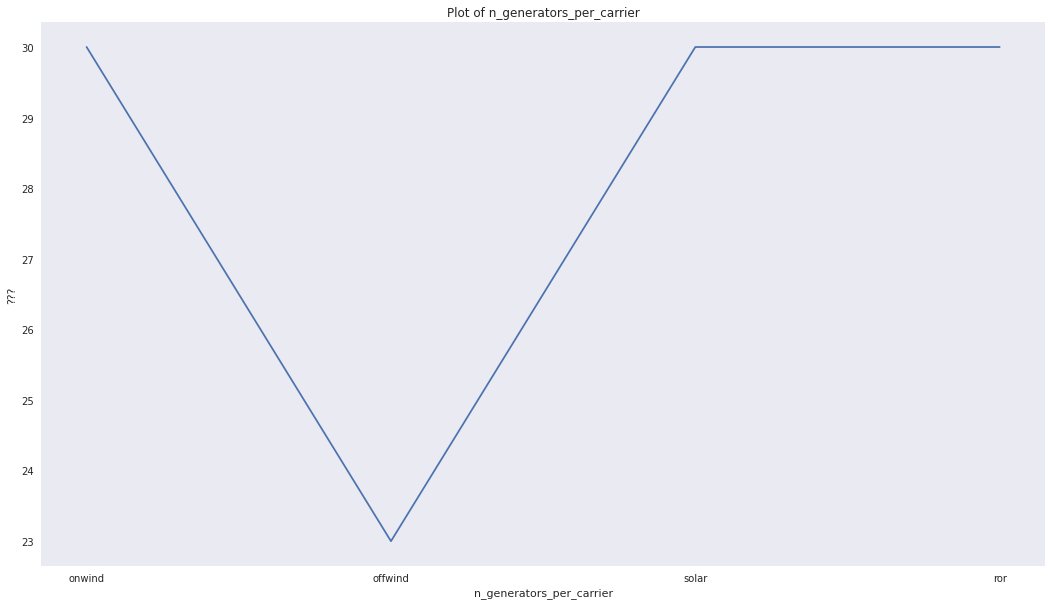

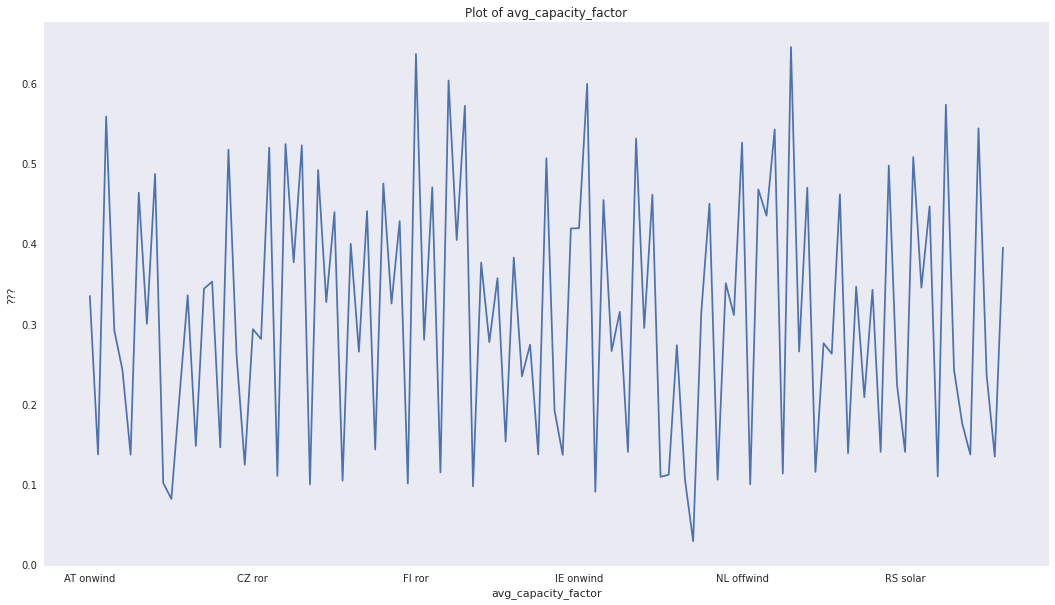

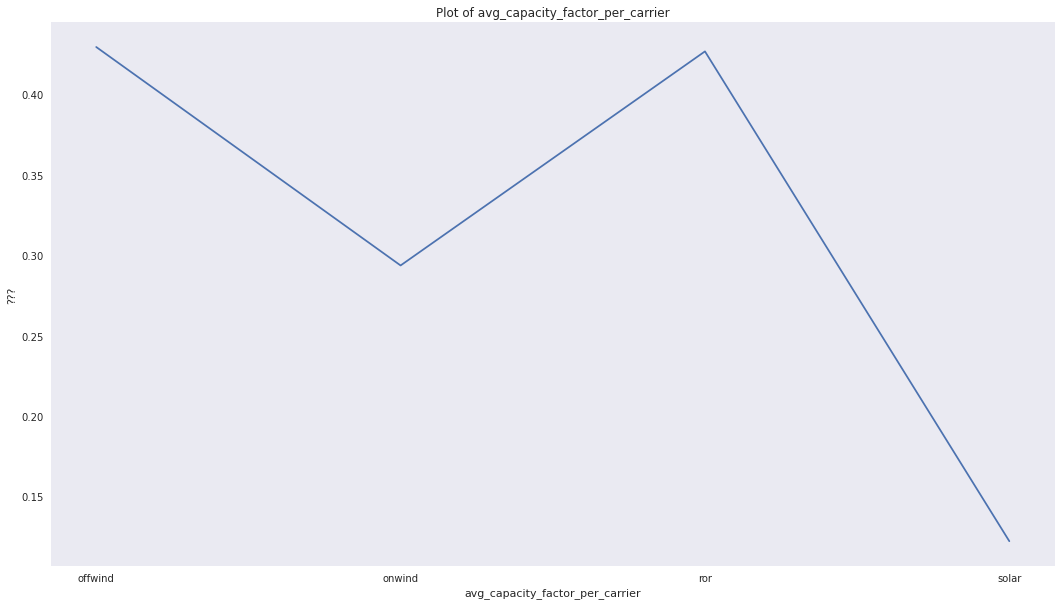

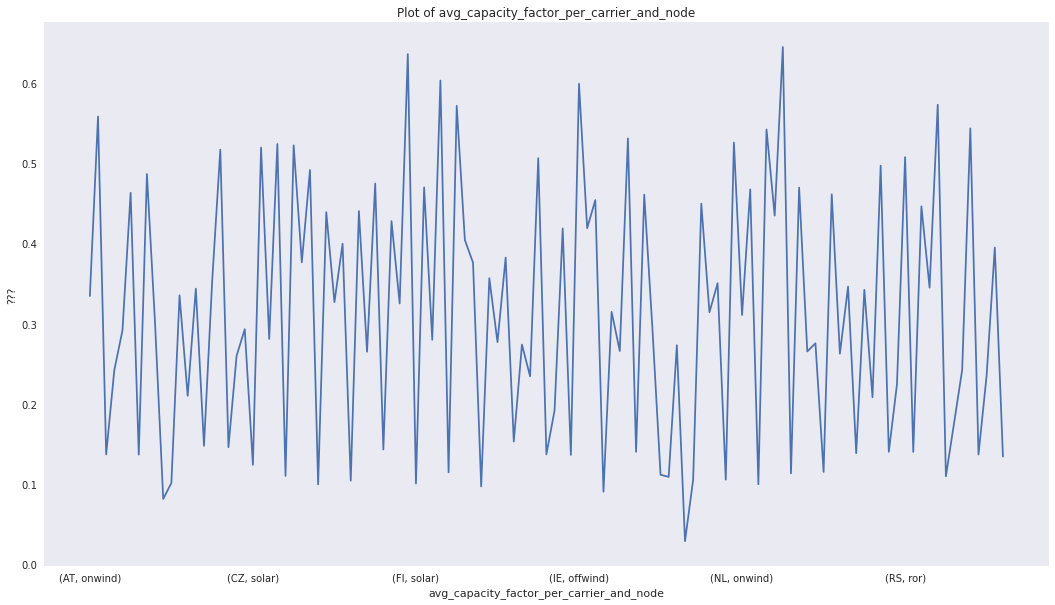

In [10]:
# Plot separate plots for each variable
for name, vals in av_cap_factors.items():
    fig, ax = plt.subplots(figsize=(18,10))

    # Do the actual plotting:
    if isinstance(vals, pd.core.series.Series):
        vals.plot()
    else:
        ax.plot(vals)

    ax.set(xlabel=name, ylabel='???', title=f"Plot of {name}")
    ax.grid()

    plt.show()
    fig.tight_layout()

#### Low generation events:

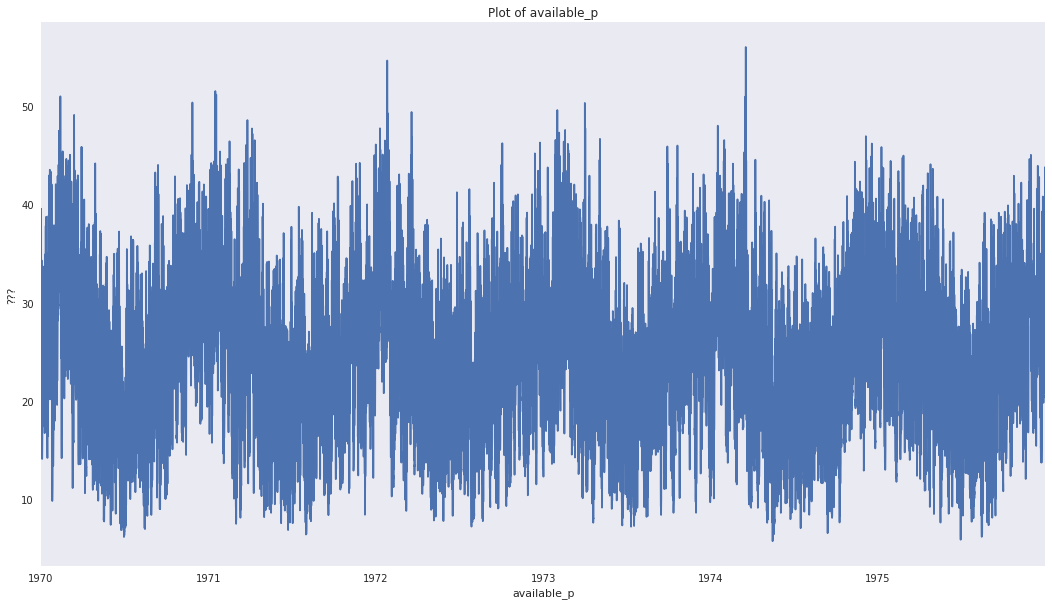

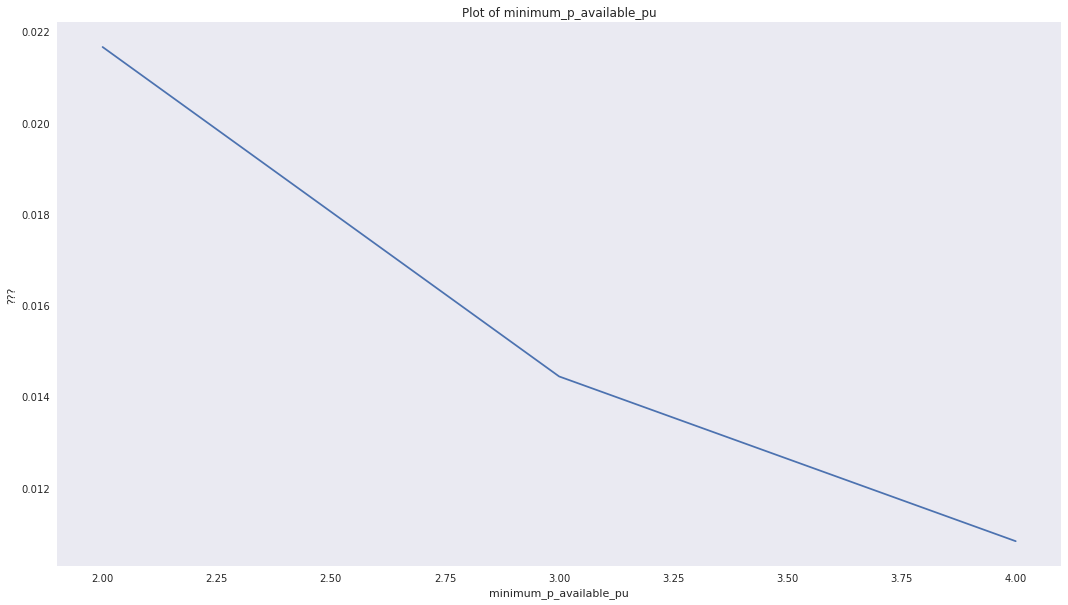

In [11]:
# Plot separate plots for each variable
for name, vals in low_gen_events.items():
    fig, ax = plt.subplots(figsize=(18,10))

    # Do the actual plotting:
    if isinstance(vals, pd.core.series.Series):
        vals.plot()
    else:
        ax.plot(vals)

    ax.set(xlabel=name, ylabel='???', title=f"Plot of {name}")
    ax.grid()

    plt.show()
    fig.tight_layout()

#### Complementarity:

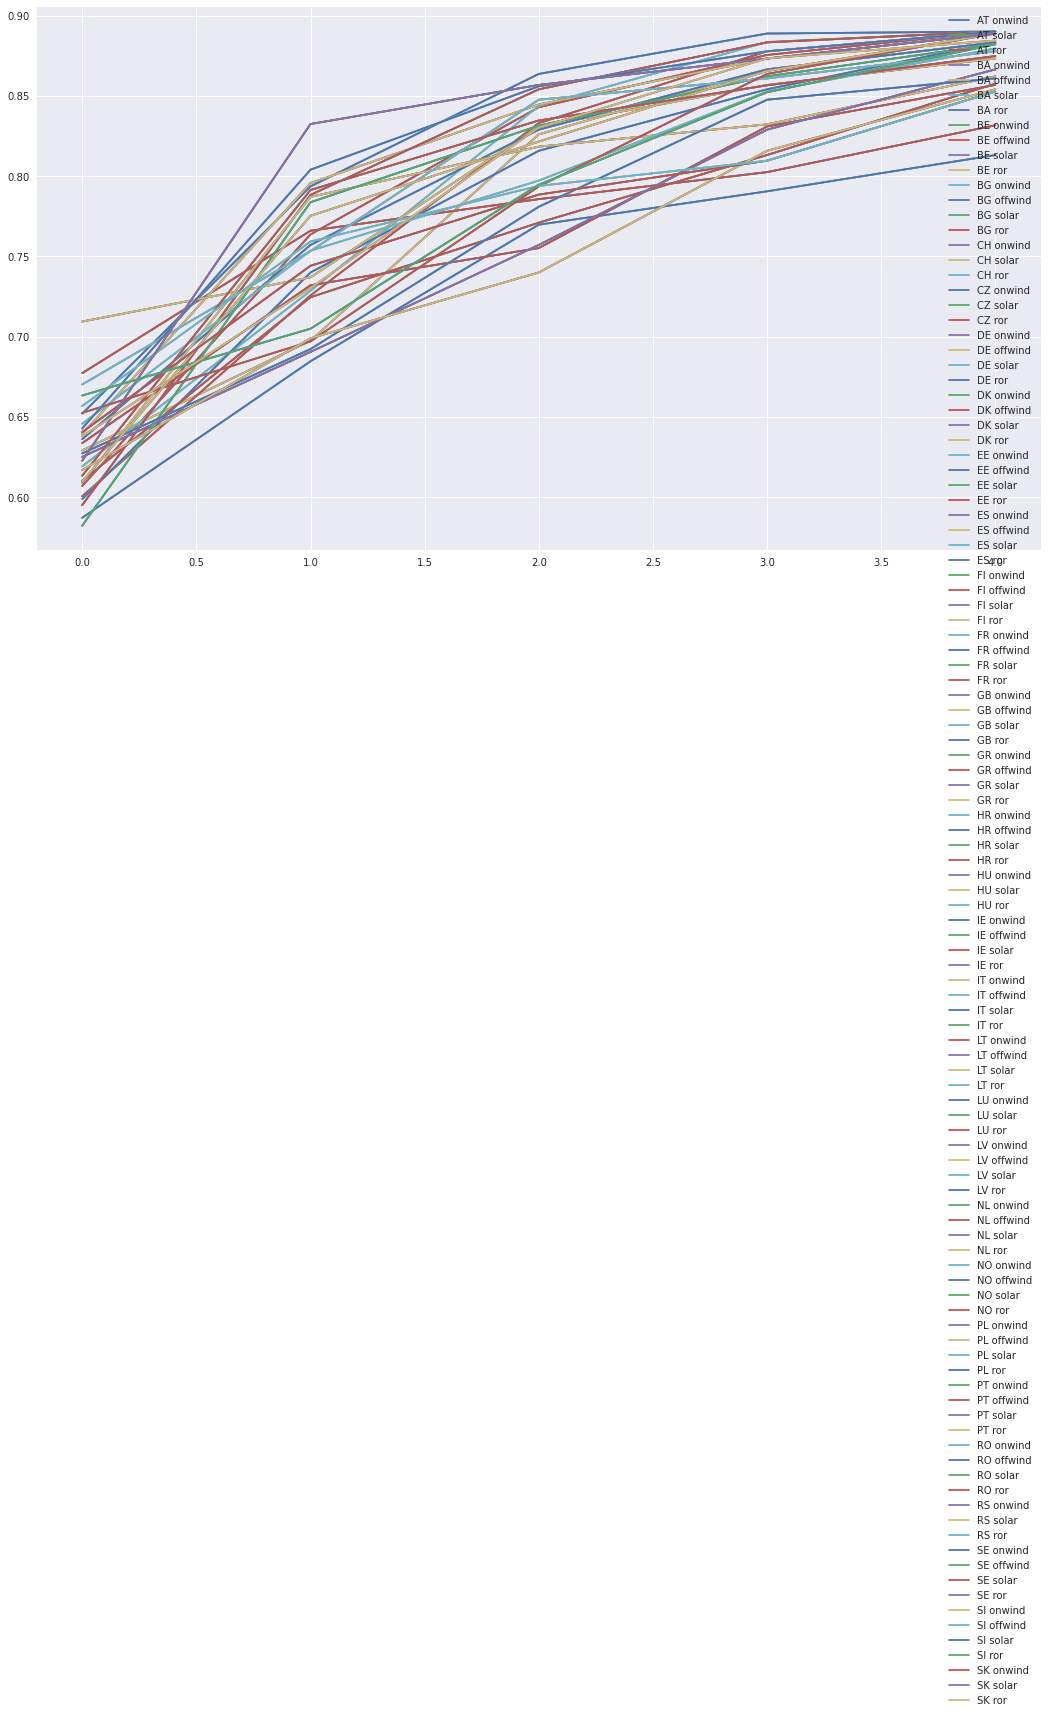

In [12]:
# Plot separate plots for each variable

current_name = ""
fig, ax = plt.subplots(figsize=(18,10))
for name, vals in complementarity_seasonal.items():
    vals.plot()

ax.legend()
plt.show()
fig.tight_layout()

### Plots for the simulation outputs

#### Shares plots:

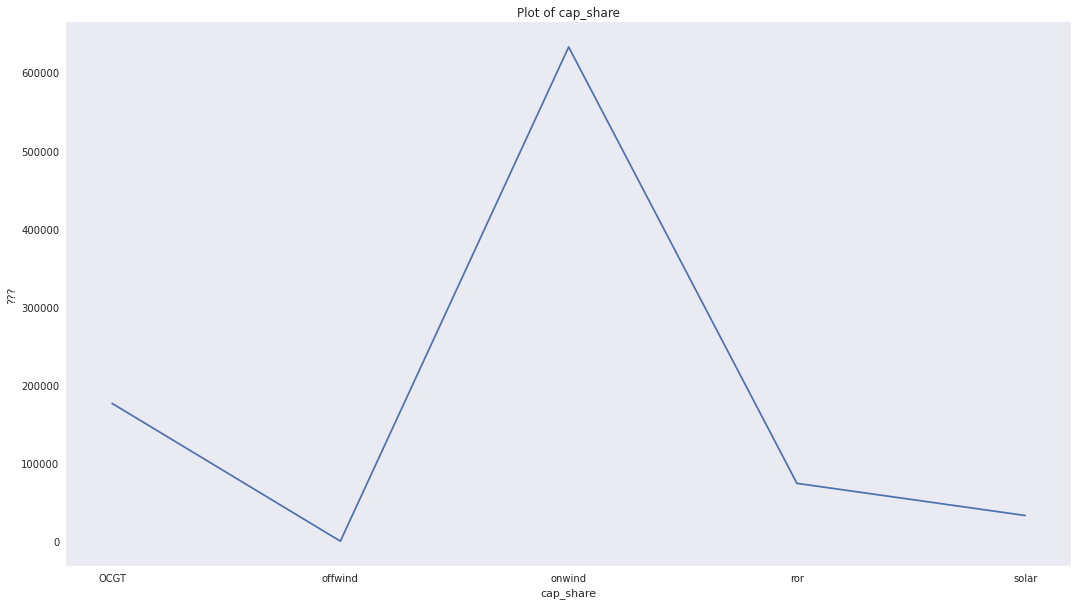

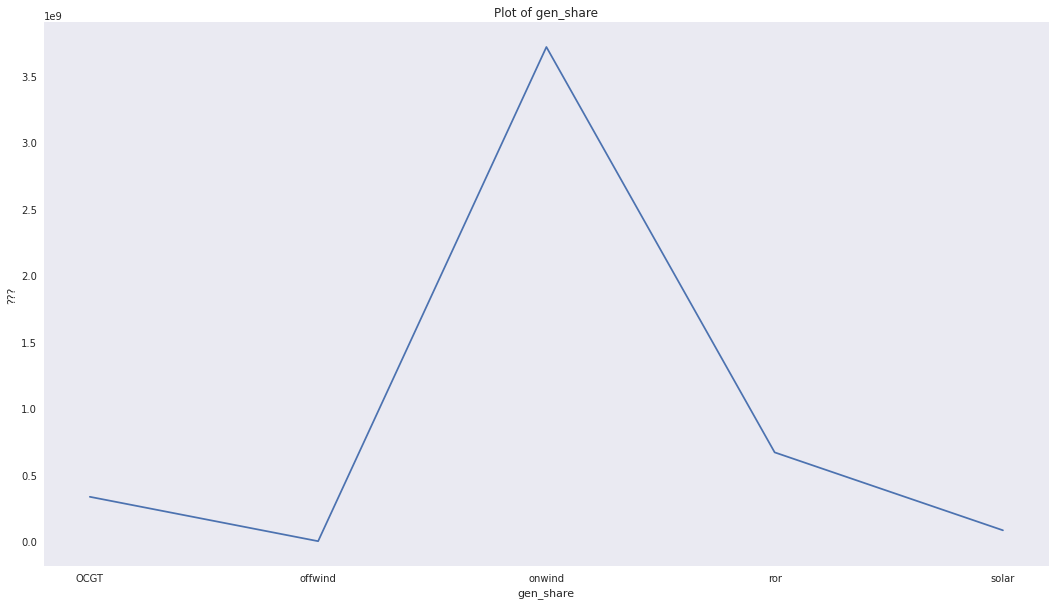

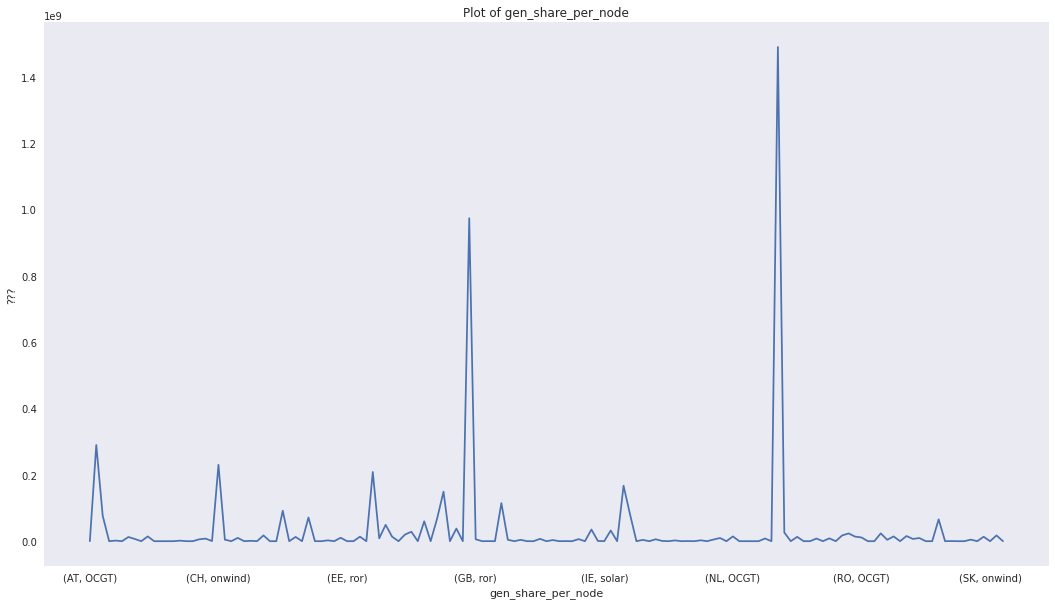

In [13]:
# Plot separate plots for each variable
for name, vals in shares.items():
    fig, ax = plt.subplots(figsize=(18,10))

    # Do the actual plotting:
    if isinstance(vals, pd.core.series.Series):
        vals.plot()
    else:
        ax.plot(vals)

    ax.set(xlabel=name, ylabel='???', title=f"Plot of {name}")
    ax.grid()

    plt.show()
    fig.tight_layout()

#### Costs plots:

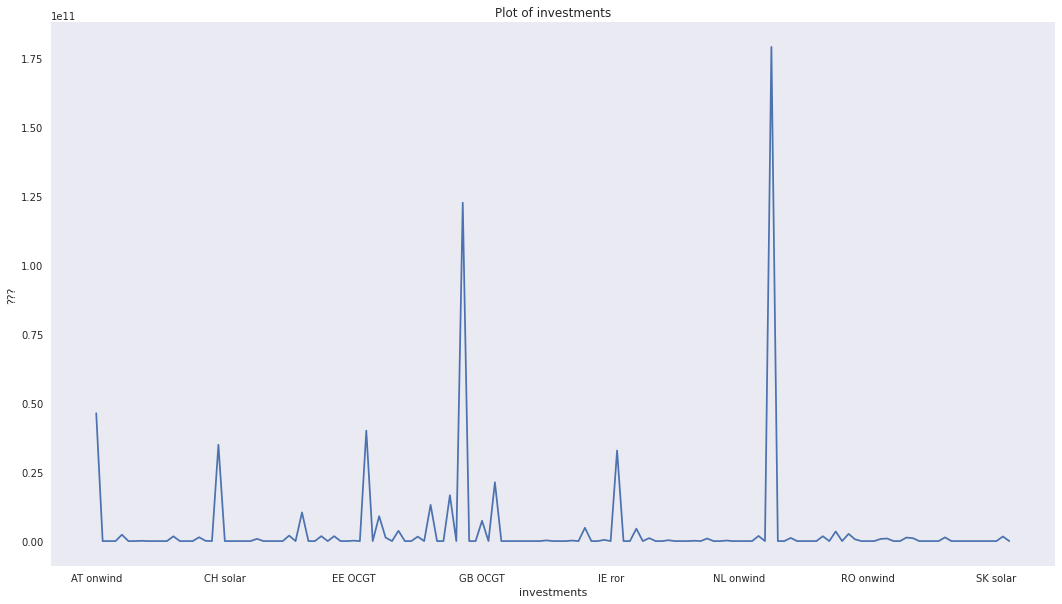

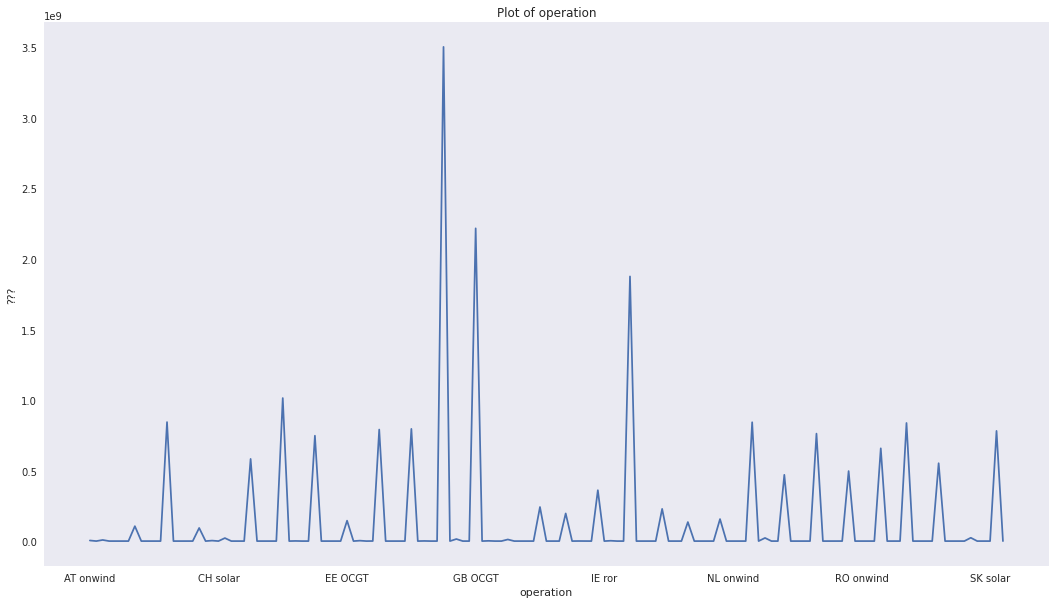

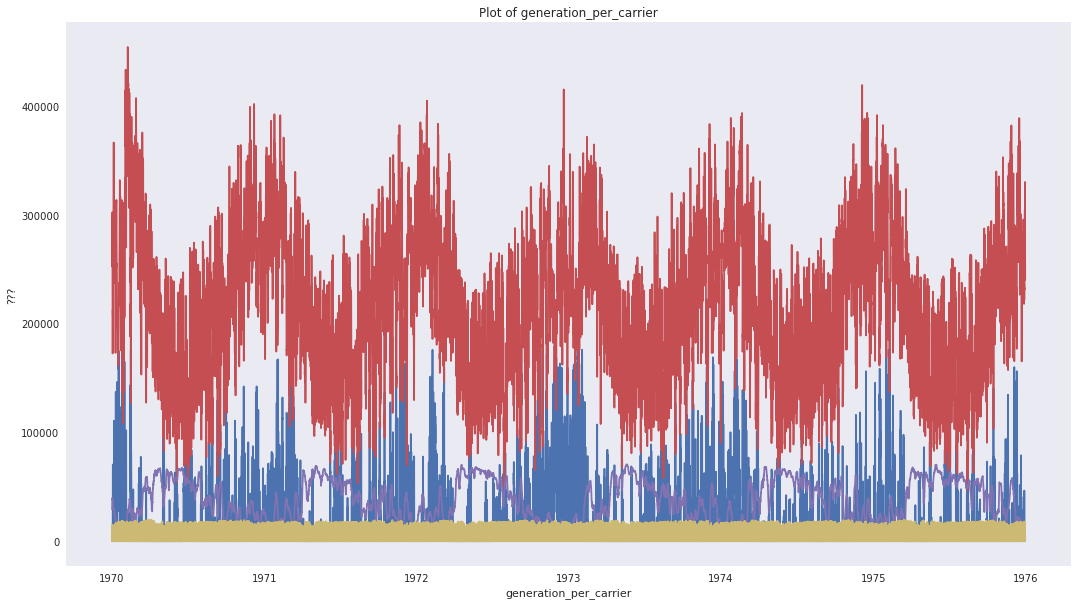

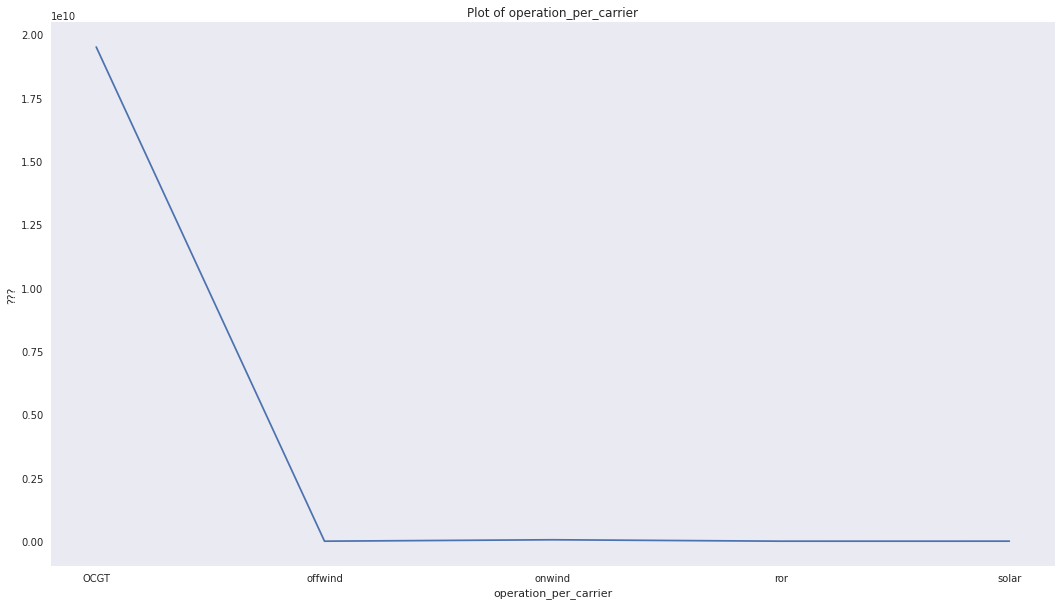

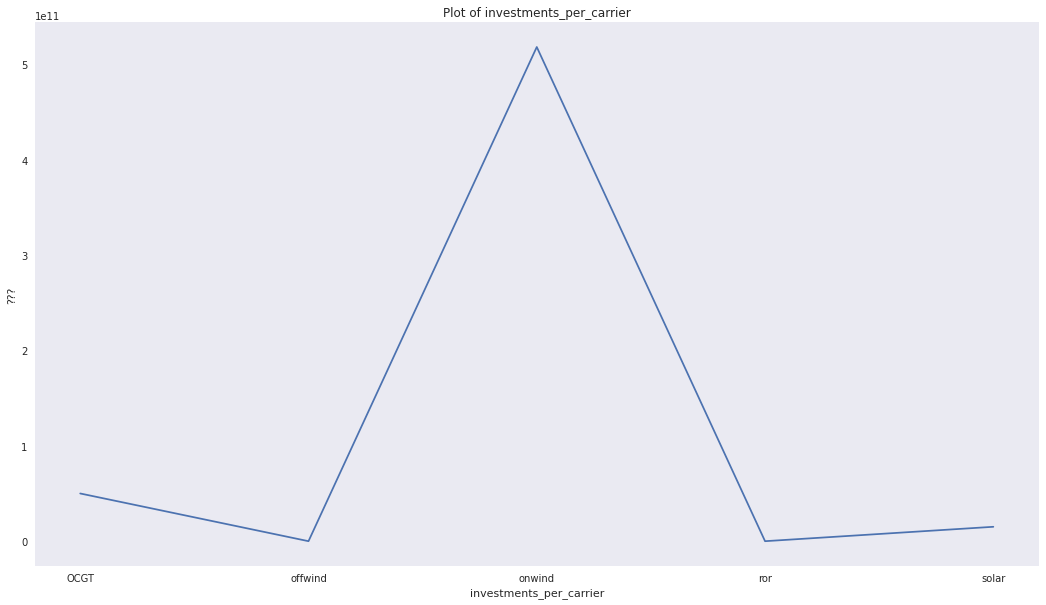

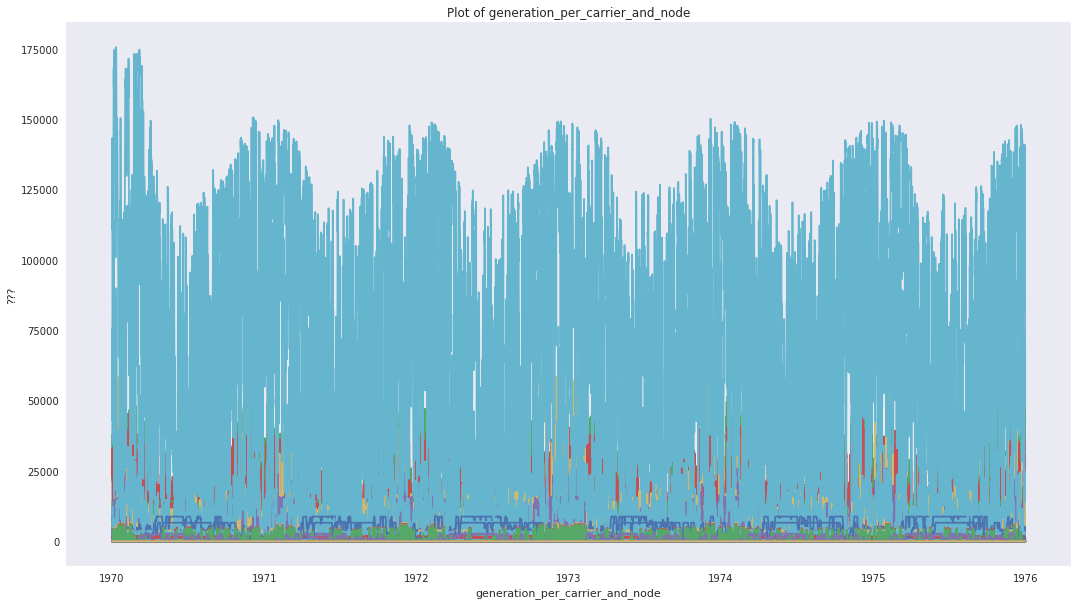

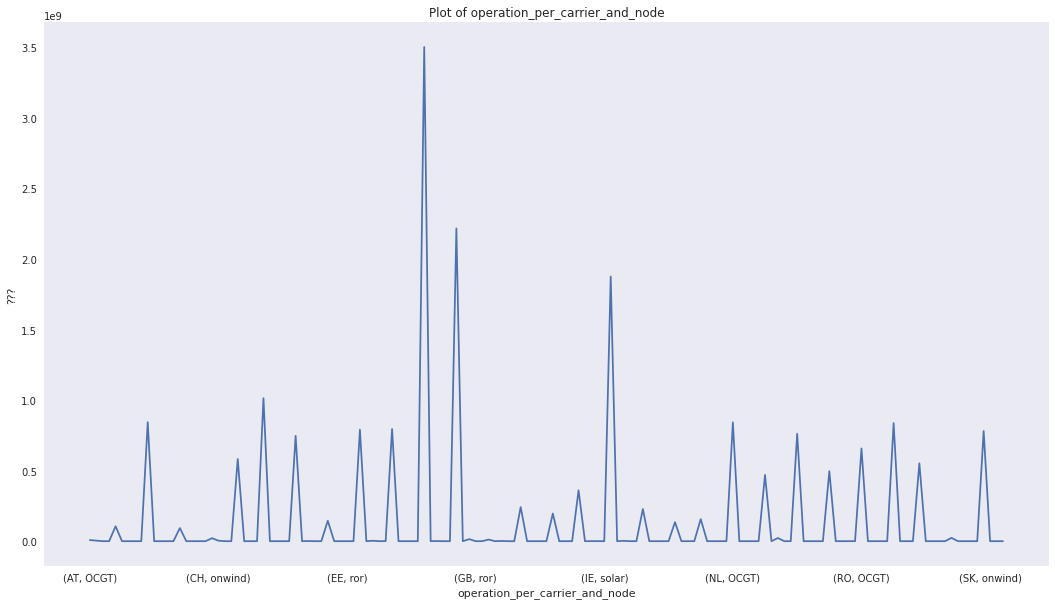

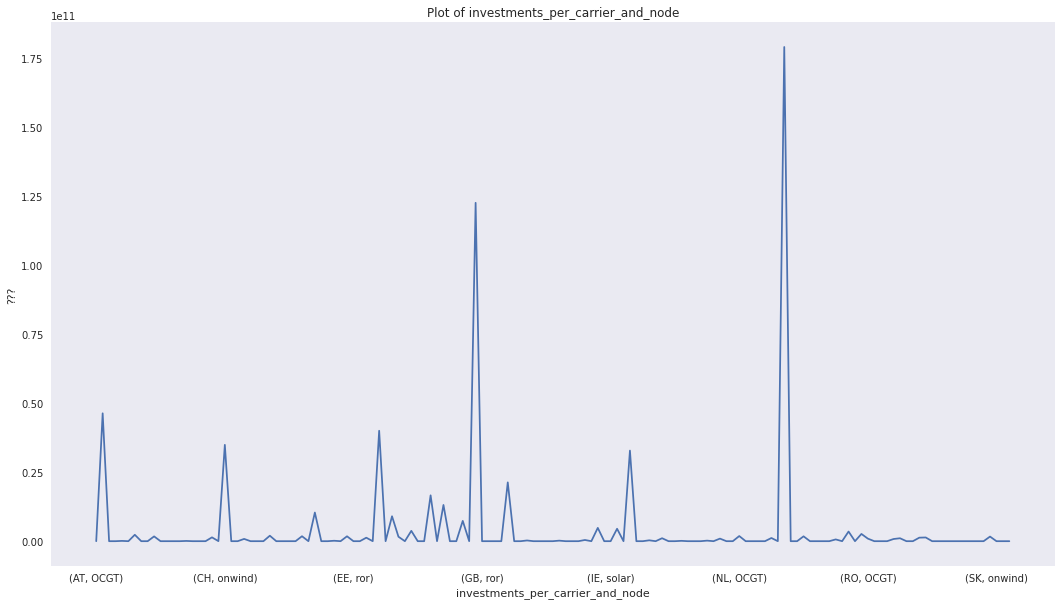

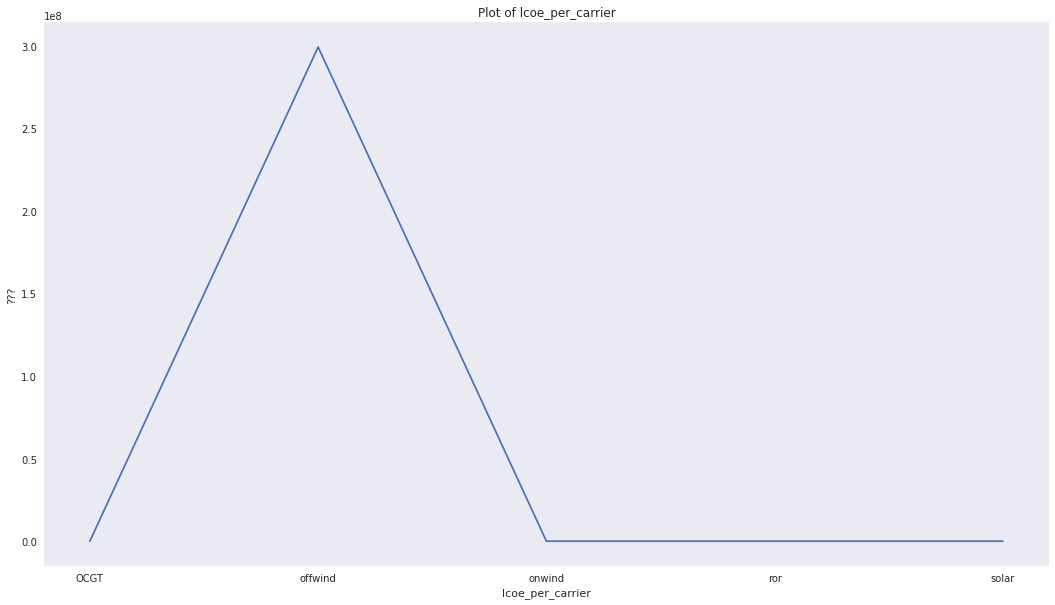

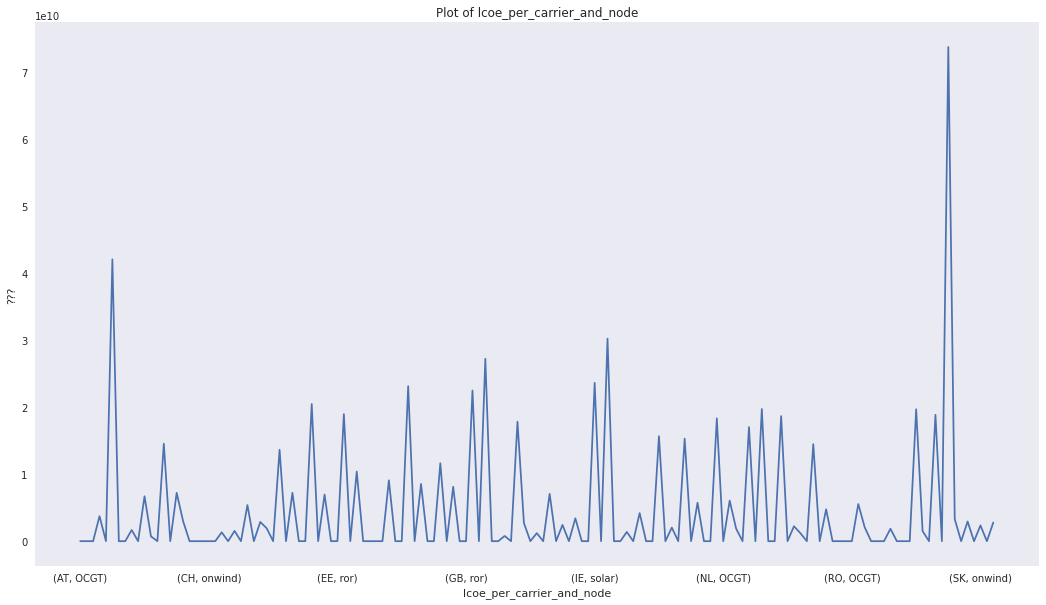

In [14]:
# Plot separate plots for each variable
for name, vals in costs.items():
    fig, ax = plt.subplots(figsize=(18,10))

    # Do the actual plotting:
    if isinstance(vals, pd.core.series.Series):
        vals.plot()
    else:
        ax.plot(vals)

    ax.set(xlabel=name, ylabel='???', title=f"Plot of {name}")
    ax.grid()

    plt.show()
    fig.tight_layout()